# Libraries

In [3]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 188.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [24]:
# Libraries
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, hour, dayofweek, month, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
spark = SparkSession.builder \
    .appName("NYC Taxi 2020-2024") \
    .config("spark.driver.memory", "40g") \
    .config("spark.executor.memory", "50g") \
    .config("spark.driver.cores", "4") \
    .config("spark.executor.cores", "46") \
    .getOrCreate()

# Import Data

In [3]:
# IMPORT 5 YEARS

base_path = "/expanse/lustre/projects/uci150/rvasappanavara/shared/nyc_taxi_data/"
file_paths = sorted(glob(f"{base_path}/yellow_tripdata_202[0-4]-*.parquet"))

# Fixes schema compatibility errors
dfs = []

for path in file_paths:
    df = spark.read.parquet(f"file://{path}")
    df = df.withColumn("airport_fee", col("airport_fee").cast("double"))
    dfs.append(df)

raw_df = dfs[0]
for df in dfs[1:]:
    raw_df = raw_df.unionByName(df)

174689444

In [4]:
# Shape of df
num_rows = raw_df.count()
num_cols = len(raw_df.columns)
print(f"Rows: {num_rows}, Columns: {num_cols}")

Rows: 174689444, Columns: 19


In [5]:
raw_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [6]:
raw_df.describe().show()

+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+---------------------+------------------+--------------------+-------------------+
|summary|           VendorID|   passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|           mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        airport_fee|
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+---------------------+------------------+-------------------

# EDA & Preprocessing for Fare Prediction

In [7]:
df = raw_df

In [8]:
# Examining possible outlier fares

print("Zero or negative fares:", df.filter(col("fare_amount") <= 0).count())
print("Fares < $3:", df.filter(col("fare_amount") < 3).count())
print("Fares > $100:", df.filter(col("fare_amount") > 100).count())
print("Fares > $200:", df.filter(col("fare_amount") > 200).count())

Zero or negative fares: 1669498
Fares < $3: 2216730
Fares > $100: 363769
Fares > $200: 43340


### Standard City Rate, \$3 initial charge
#### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245
### Removing fares under 3 dollars because that is the minimum charge and removing outlier fares above 200 dollars.

In [9]:
# Removing outliers, keeping fares between $3-$200
df = df.filter((col("fare_amount") >= 3) & (col("fare_amount") <= 200))

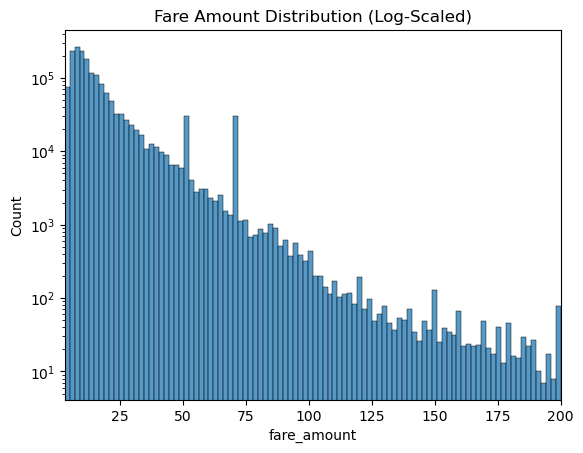

In [11]:
# Scatterplot of fare distribution

# Using sample of data
scatterplot_sample = df.select("fare_amount").sample(fraction=0.01, seed=2).toPandas()

sns.histplot(scatterplot_sample["fare_amount"], bins=100)
plt.xlim(3, 200)  
plt.yscale("log")  # Log scale  to show more 
plt.title("Fare Amount Distribution (Log-Scaled)")
plt.show()

### Most of the spikes are around round numbers, with the biggest spike at $70. 

### After some research, its very common to charge flat rates on standard trips like to the airport. Specifically to JFK is $70.

### John F. Kennedy Airport (JFK), To or from Manhattan (Rate Code 2), \$70 "Flat Fare."
#### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

In [12]:
# Extracting time based columns
# Trip time in minutes
df = df.withColumn("trip_time_minutes", (unix_timestamp("tpep_dropoff_datetime") - 
                                         unix_timestamp("tpep_pickup_datetime")) / 60)
# Fare per minute
df = df.withColumn("fare_per_min", col("fare_amount") / col("trip_time_minutes"))
# Fare per mile
df = df.withColumn("fare_per_mile", col("fare_amount") / col("trip_distance"))

In [13]:
# Extracting time based columns
df = df.withColumn("hour", hour(col("tpep_pickup_datetime"))) \
       .withColumn("dayofweek", dayofweek(col("tpep_pickup_datetime")) - 2) \
       .withColumn("month", month(col("tpep_pickup_datetime")))

# Passenger Count

<br>

### Maximum Number of Passengers - The maximum number of passengers allowed in a yellow taxicab by law is 4 in a 4-passenger taxicab or 5 in a 5-passenger taxicab.
#### https://portal.311.nyc.gov/article/?kanumber=KA-01245

In [14]:
# Filter for 1-5 passengers. 4 or 5 is max allowed by taxi law in NYC
df = df.withColumn("passenger_count", when(col("passenger_count") < 1, 1)
    .when(col("passenger_count") > 5, 5).otherwise(col("passenger_count")))

# Trip Distance EDA & Processing 

<br>

### Standard City Rate, 70 cents for every 1/5 of a mile when traveling above 12 miles per hour or per 60 seconds in slow traffic or when the vehicle is stopped.
#### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

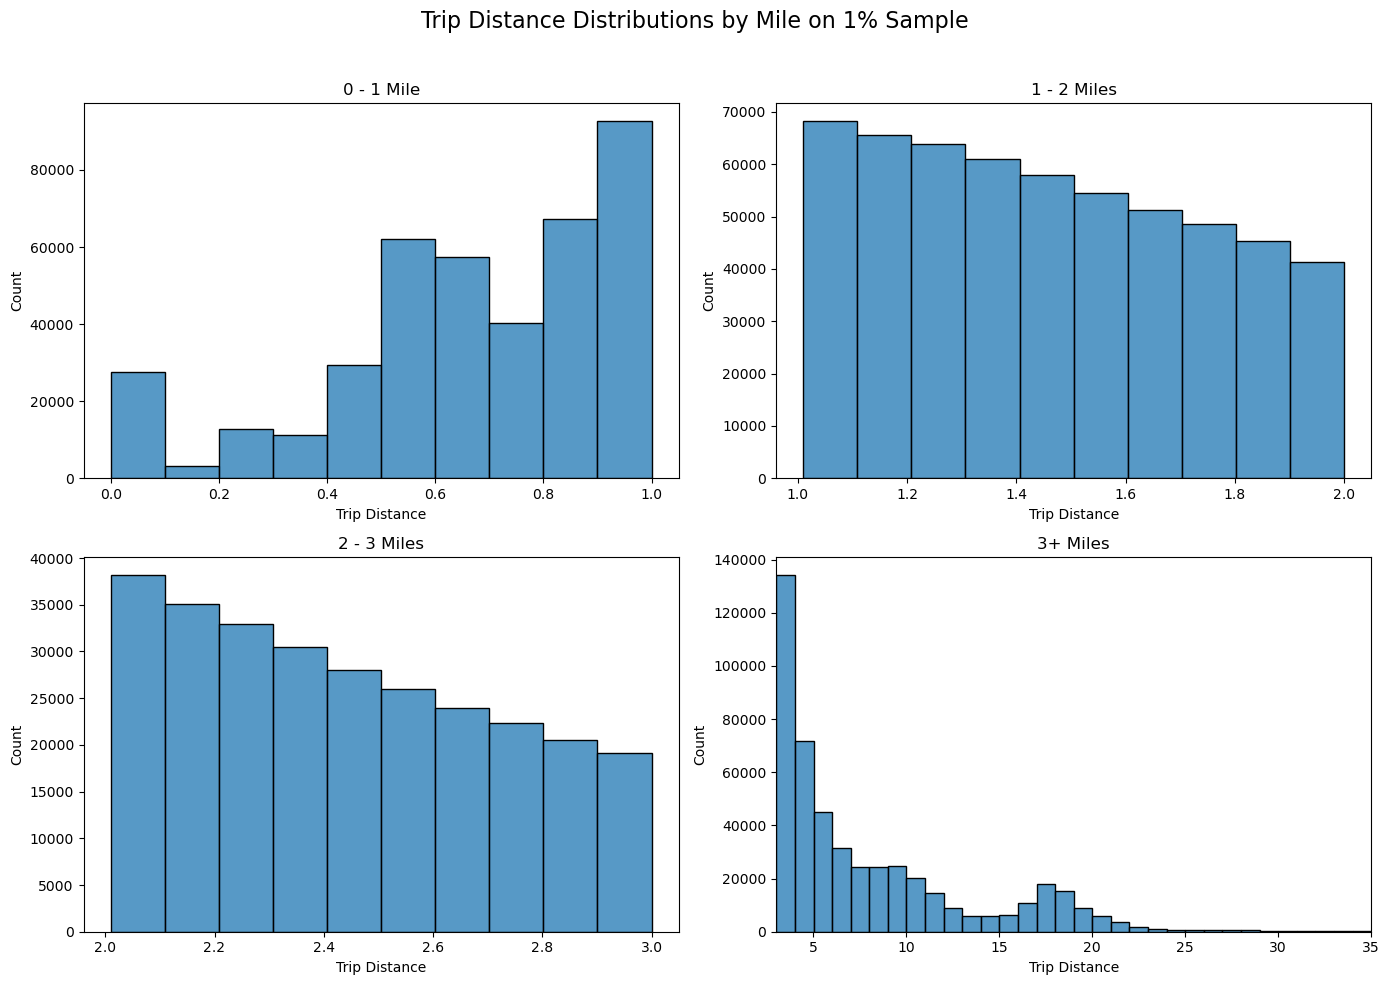

In [15]:
# Histogram of Trip Distance by Mile

# Filter sampled data for trip distance ranges
mile_0_1 = df.filter((col("trip_distance") >= 0) & (col("trip_distance") <= 1)) \
             .select("trip_distance").sample(fraction=0.01).toPandas()
mile_1_2 = df.filter((col("trip_distance") > 1) & (col("trip_distance") <= 2)) \
             .select("trip_distance").sample(fraction=0.01).toPandas()
mile_2_3 = df.filter((col("trip_distance") > 2) & (col("trip_distance") <= 3)) \
             .select("trip_distance").sample(fraction=0.01).toPandas()
mile_3_plus = df.filter((col("trip_distance") > 3) & (col("trip_distance") <= 35)) \
                .select("trip_distance").sample(fraction=0.01).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Trip Distance Distributions by Mile on 1% Sample", fontsize=16)

# 0–1 mile
sns.histplot(mile_0_1["trip_distance"], bins=10, ax=axes[0, 0])
axes[0, 0].set_title("0 - 1 Mile")
axes[0, 0].set_xlabel("Trip Distance")
axes[0, 0].set_ylabel("Count")

# 1–2 miles
sns.histplot(mile_1_2["trip_distance"], bins=10, ax=axes[0, 1])
axes[0, 1].set_title("1 - 2 Miles")
axes[0, 1].set_xlabel("Trip Distance")
axes[0, 1].set_ylabel("Count")

# 2–3 miles
sns.histplot(mile_2_3["trip_distance"], bins=10, ax=axes[1, 0])
axes[1, 0].set_title("2 - 3 Miles")
axes[1, 0].set_xlabel("Trip Distance")
axes[1, 0].set_ylabel("Count")

# 3+ miles
sns.histplot(mile_3_plus["trip_distance"], bins=32, ax=axes[1, 1])
axes[1, 1].set_title("3+ Miles")
axes[1, 1].set_xlabel("Trip Distance")
axes[1, 1].set_ylabel("Count")
axes[1, 1].set_xlim(3, 35)

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

### Most trips are short distances. The standard rate (ratecode = 1) is for NYC county only. Filtering for trips >= 0 and <= 35 miles as the distance of NYC is approx 35 miles. "...the longest distance between its boundaries, from the northeast to the southwest, is about 35 miles."

#### source: https://www.takewalks.com/blog/nyc-by-the-numbers#:~:text=The%20total%20area%20of%20the,Staten%20Island%20and%20Long%20Island.

In [16]:
# Filter Trip Distance
df = df.filter((col("trip_distance") >= 0) & (col("trip_distance") <= 35))

# RatecodeID EDA & Processing

In [17]:
metered_count = df.filter(col("RatecodeID") == 1).count()
total_count   = df.count()

print(f"Metered fare rides (RatecodeID == 1): {metered_count:,}")
print(f"Percentage of rides (RatecodeID == 1): {metered_count / total_count:.2%}")

Metered fare rides (RatecodeID == 1): 155,656,072
Percentage of rides (RatecodeID == 1): 90.31%


### Looking at ratecode = 1, this is metered/standard rate rides. 90% of the rides are metered. Rates codes such as 2 and 3 are flat rates & negociated fares.

#### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

#### Below are the rate codes and their meaning. 
##### 1= Standard rate
##### 2=JFK
##### 3=Newark
##### 4=Nassau or Westchester
##### 5=Negotiated fare
##### 6=Group ride

In [18]:
# Filtering to RatecodeID == 1
df = df.filter(col("RatecodeID") == 1)

# Feature Engineering 

# *Still need to figure out error below, works on local notebook

In [22]:
# Correlation to fare amount

col = ["trip_distance",
       "trip_time_minutes",
       "fare_per_min",
       "fare_per_mile",
       "passenger_count",
       "hour",
       "dayofweek",
       "month",
       "payment_type",
       "congestion_surcharge",
       "tolls_amount",
       "tip_amount",
       "fare_amount"] # Target column for sampling

# Sampling 5%
corr_df = df.select(col).sample(fraction=0.05, seed=2).toPandas()

fare_corr = corr_df.corr(numeric_only=True)["fare_amount"].sort_values(ascending=False)
print(fare_corr)

fare_amount             1.000000
trip_distance           0.911714
tip_amount              0.553248
tolls_amount            0.475348
month                   0.049514
hour                    0.010000
fare_per_min            0.006666
trip_time_minutes       0.002714
passenger_count         0.002652
dayofweek              -0.012248
payment_type           -0.019350
fare_per_mile          -0.095948
congestion_surcharge   -0.287631
Name: fare_amount, dtype: float64


### trip_distance, tip_amount and tolls_amount all have strong to moderate correlations to fare_amount. 
### Tip amount will not be used because tips are not known until the ride is over. Tip amount is discretionary, we are predicting the price of fare  for a customer's ride, not the fare plus tip. 
### Adding trip_in_minutes reduces rmse by more than half. This is likely because riders are also charged per minute. 
### "70 cents for every 1/5 of a mile when traveling above 12 miles per hour or per 60 seconds in slow traffic or when the vehicle is stopped"
#### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

In [25]:
# Filter extreme outliers for trip_time_minutes and tolls_amount

df = df.filter((col("trip_time_minutes") >= 0) & (col("trip_time_minutes") <= 1500) &
               (col("tolls_amount") >= 0) & (col("tolls_amount") <= 100))

df.cache()
df.count()

155652442

In [26]:
# Data remaining after processing
percent_remaining = (df.count() / raw_df.count()) * 100

print(f"Original row count: {raw_df.count()}")
print(f"Filtered row count: {df.count()}")
print(f"\nPercentage of data retained: {percent_remaining:.2f}%")

Original row count: 174689444
Filtered row count: 155652442

Percentage of data retained: 89.10%


### We retained 89%% of the overall data after processing.

# Model

In [28]:
features = ["trip_distance", "trip_time_minutes", "tolls_amount"]
target = "fare_amount"

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_ml = assembler.transform(df).select("features", target)

df_ml.cache()
df_ml.count()

train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=2)

In [29]:
train_data.count()

124512307

In [30]:
# Baseline Linear Regression Model

lr = LinearRegression(featuresCol="features", labelCol="fare_amount")
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", 
                                     predictionCol="prediction", 
                                     metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="fare_amount", 
                                    predictionCol="prediction", 
                                    metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="fare_amount", 
                                   predictionCol="prediction", 
                                   metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Linear Reg RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

Linear Reg RMSE: 4.34
MAE: 2.96
R² Score: 0.8336


In [31]:
# LightGB Model

# USING SAMPLE FOR INITIAL RUN, NEED TO FIGURE OUT MEMORY
train_pd = train_data.select("features", "fare_amount").sample(fraction=.1, seed=2).toPandas()
test_pd  = test_data.select("features", "fare_amount").sample(fraction=.1, seed=2).toPandas()

# Extract features from Vector column
X_train = np.vstack(train_pd["features"])
y_train = train_pd["fare_amount"]

X_test = np.vstack(test_pd["features"])
y_test = test_pd["fare_amount"]


lgb_model = LGBMRegressor(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=2,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM RMSE: {rmse_lgb:.2f}")
print(f"MAE: {mae_lgb:.2f}")
print(f"R² Score: {r2_lgb:.4f}")


LightGBM RMSE: 2.72
MAE: 1.95
R² Score: 0.9343


#### Model performs nearly the same on 10% sample as it did locally on full dataset

In [30]:
# LightGB Model

# NON SAMPLED
train_pd = train_data.select("features", "fare_amount").toPandas()
test_pd  = test_data.select("features", "fare_amount").toPandas()

# Extract features from Vector column
X_train = np.vstack(train_pd["features"])
y_train = train_pd["fare_amount"]

X_test = np.vstack(test_pd["features"])
y_test = test_pd["fare_amount"]


lgb_model = LGBMRegressor(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=2,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM RMSE: {rmse_lgb:.2f}")
print(f"MAE: {mae_lgb:.2f}")
print(f"R² Score: {r2_lgb:.4f}")


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_com

AssertionError: Undefined error message parameter for error class: CANNOT_PARSE_DATATYPE. Parameters: {'error': 'An error occurred while calling o820.schema'}

## Light GBM has the most accuracy "out of the box."

# LGB Model Evaluation 

## Residuals

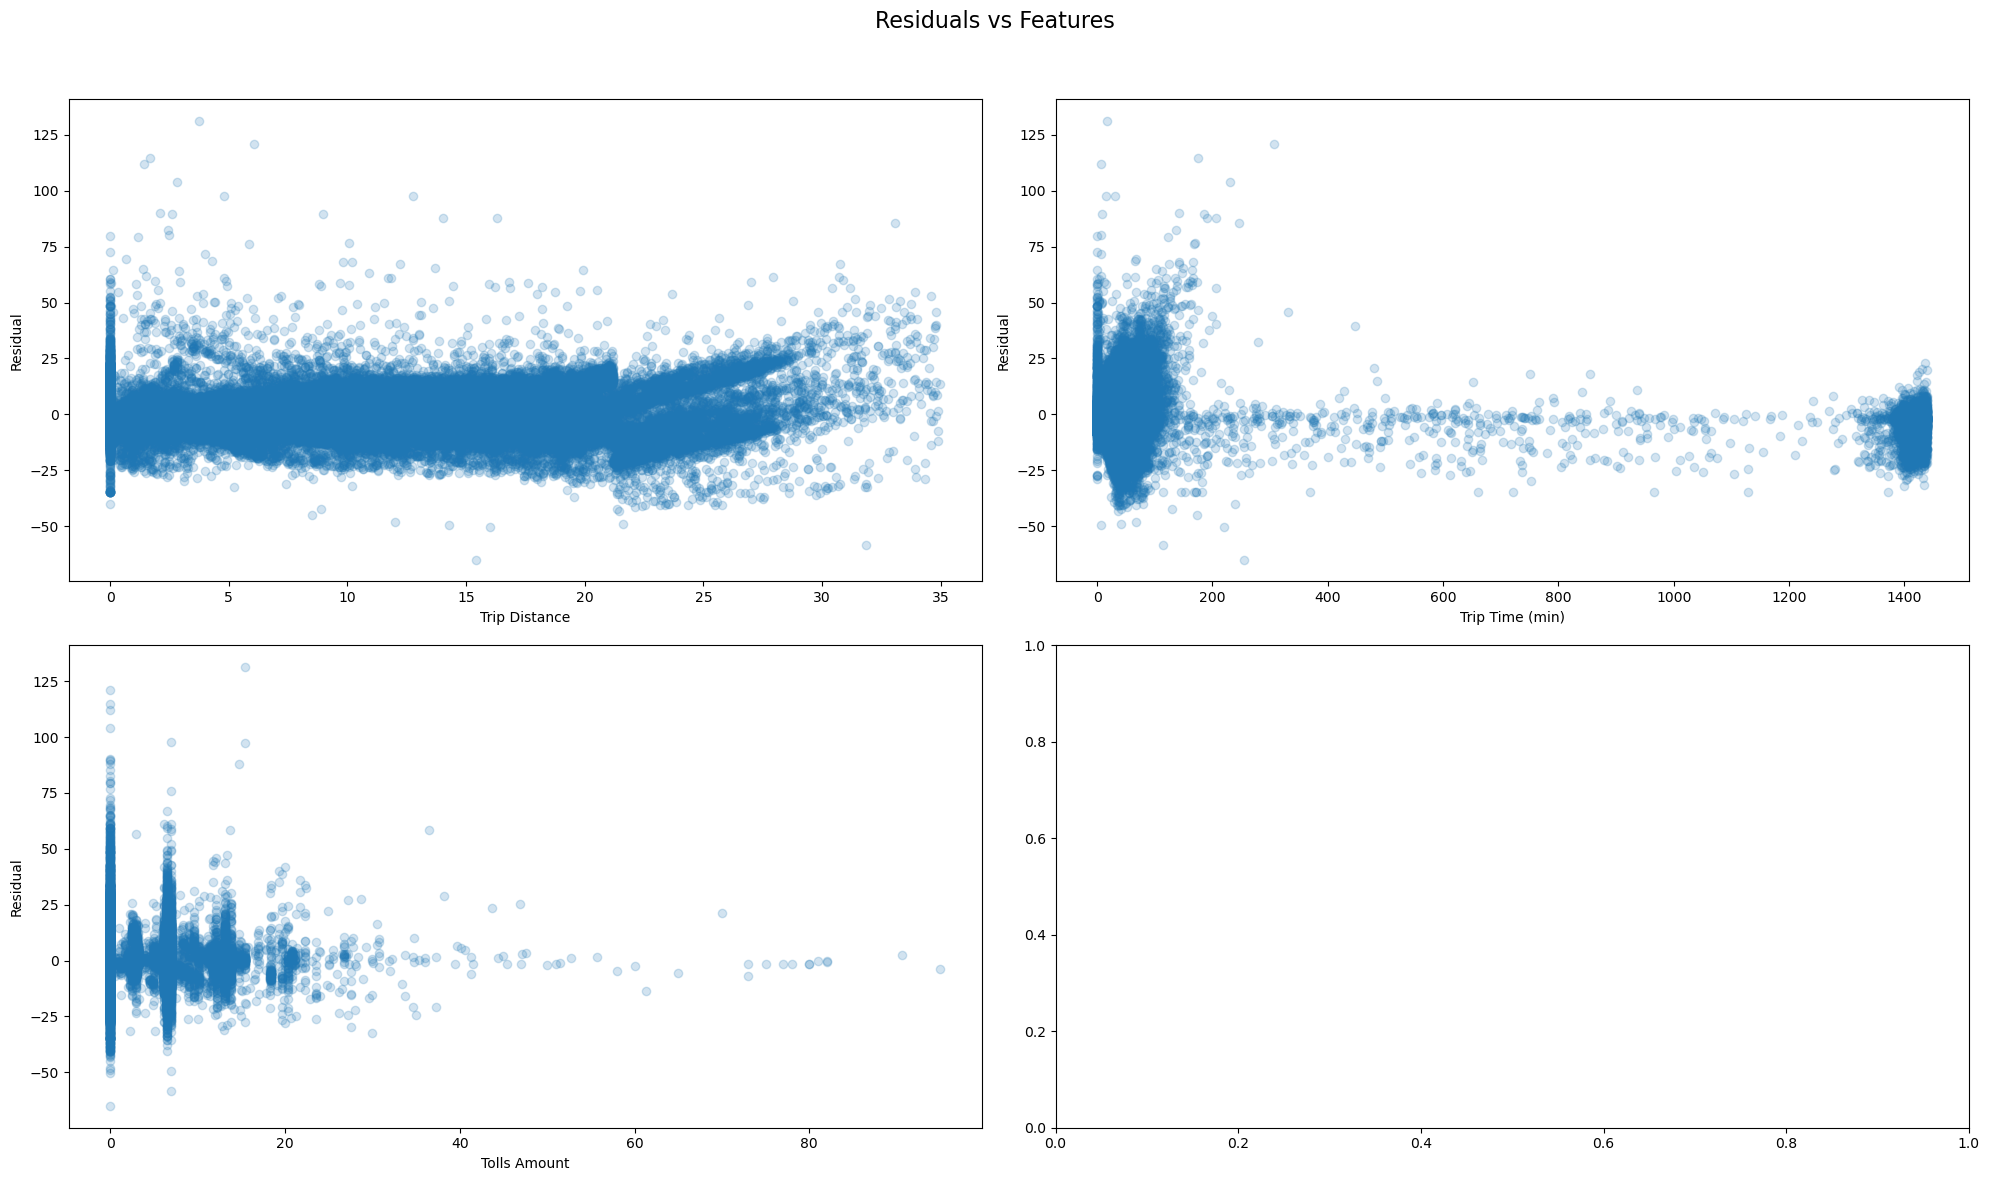

In [33]:
feature_names = ["trip_distance", "trip_time_minutes", "tolls_amount"]

# Convert feature vectors to a 2D array
X_test_array = np.vstack(test_pd["features"])
X_test_df = pd.DataFrame(X_test_array, columns=feature_names)

# Calculate residuals
resid = y_test - y_pred_lgb

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle("Residuals vs Features", fontsize=16)

axes[0,0].scatter(X_test_df["trip_distance"], resid, alpha=0.2)
axes[0,0].set_xlabel("Trip Distance")
axes[0,0].set_ylabel("Residual")

axes[0,1].scatter(X_test_df["trip_time_minutes"], resid, alpha=0.2)
axes[0,1].set_xlabel("Trip Time (min)")
axes[0,1].set_ylabel("Residual")

axes[1,0].scatter(X_test_df["tolls_amount"], resid, alpha=0.2)
axes[1,0].set_xlabel("Tolls Amount")
axes[1,0].set_ylabel("Residual")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [34]:
print(f"Total training rows: {df.count()}")
print(f"Trips under 5 miles: {df.filter(col('trip_distance') < 5).count()}")
print(f"Percentage under 5 miles: {df.filter(col('trip_distance') < 5).count() / df.count() * 100:.2f}%")

Total training rows: 155652442
Trips under 5 miles: 136223949
Percentage under 5 miles: 87.52%


# UPDATE ANALYSIS *****

## 10 fold Cross Validation

In [ ]:
# 10 fold CV
def root_mean_squared_error(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

# 10 fold Cross Validation 
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
neg_rmse = cross_val_score(lgb_model, X, y, scoring=rmse_scorer, cv=10)

# Report results
print(f"Cross-validated RMSE scores: {-neg_rmse}")
print(f"Mean CV RMSE: {-neg_rmse.mean():.4f}")